<a href="https://colab.research.google.com/github/aguilin1/tda_ai_text_generation/blob/main/tda_ai_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/aguilin1/tda_ai_text_generation.git
!pip install nltk
!pip install Ripser

Cloning into 'tda_ai_text_generation'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 161 (delta 15), reused 0 (delta 0), pack-reused 123 (from 2)
Receiving objects: 100% (161/161), 7.74 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (71/71), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=acf8a3b97a7e76aa7e43186111d3c2b89960b9cd9a72f4da078b1c6289d0bea2
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [2]:
# set up Ripser for use (run this just once)

from ripser import ripser, Rips
from persim import plot_diagrams

In [3]:
# Functions ---
# cosSimDistanceMatrix: creates cosine similarity distance matrix
# vrFiltration: takes a distance matrix and computes Vietoris-Rips filtration

from sklearn.metrics.pairwise import cosine_similarity
import itertools
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def smoothing(embeddings):
  number_sentences = embeddings.shape[0]
  original_embeddings = embeddings.copy()
  for i in range(number_sentences):
    smoothed = original_embeddings[safe_index(i -3, number_sentences)]/8.0 +\
      original_embeddings[safe_index(i -2, number_sentences)]/4.0 + \
      original_embeddings[safe_index(i -1, number_sentences)]/2.0 + \
      original_embeddings[i] + \
      original_embeddings[safe_index(i +1, number_sentences)]/2.0 + \
      original_embeddings[safe_index(i +2, number_sentences)]/4.0 + \
      original_embeddings[safe_index(i +3, number_sentences)]/8.0
    embeddings[i] = smoothed
  return embeddings

def safe_index(i, total_n):
  if i < 0:
    return i * -1
  elif i >= total_n-1:
    return total_n -1 - (i % total_n)
  else:
    return i


def angular_distance(embeddings, index_1, index_2):
  cos_sim = cosine_similarity(embeddings[index_1].reshape(1, -1),\
                              embeddings[index_2].reshape(1, -1))[0][0]

  dist = 2 * np.arccos(cos_sim) / np.pi
  return dist

# input a single array of embeddings
def angular_distance_matrix(embeddings, time_skeleton = False):
  # get # of data points in each sample
  n_dpts = embeddings.shape[0]
  # preallocate distance matrix
  angular_distances = np.zeros((n_dpts, n_dpts))
  # Label each data point in order starting at 0, 1, 2, ...
  # Distance between data point i and data point j is in (i,j) entry of matrix
  # Matrix will be upper triangular
  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      dist = angular_distance(embeddings, pair1_i, pair2_i)
    angular_distances[pair1_i][pair2_i] = dist
    angular_distances[pair2_i][pair1_i] = dist
  return angular_distances


def mixed_distance_matrix(bow_embeddings, bert_embeddings, alpha, time_skeleton = False):
  # This should align with the tokens (number of sentences), so match between types
  n_dpts = bert_embeddings.shape[0]

  cosSimDistances = np.zeros((n_dpts, n_dpts))

  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      distance_bow = angular_distance(bow_embeddings, pair1_i, pair2_i)
      distance_bert = angular_distance(bert_embeddings, pair1_i, pair2_i)
      dist = alpha * distance_bow + (1 - alpha) * distance_bert

    cosSimDistances[pair1_i][pair2_i] = dist
    cosSimDistances[pair2_i][pair1_i] = dist
  return cosSimDistances

# input a symmetric distance matrix and this function will return birth and
# death homology data for the V-R complex
def ripserFiltration(distanceMat, maxDim=2):
  # Here's one way to use Ripser
  # examples and instructions are here:
  # https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
  # https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix

  # This version uses the distance matrix input, which is what we want
  birthDeathPairs = ripser(distanceMat, distance_matrix=True, maxdim=maxDim)['dgms']

  # diagrams is a vector of vectors where each element of each
  # vector is [birth epoch, death epoch] and the vectors are in increasing order
  # of homology (H0, H1, H2, etc.).
  return birthDeathPairs

In [55]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

def diagram_sizes(dgms):
    return {f"H_{i}": len(d) for i, d in enumerate(dgms)}

def load_cached_embeddings(abstract_type, embedding_type):
  DATA_FILE_BASE = '/content/tda_ai_text_generation/data/{}_encodings_{}-{}.pkl'

  bert_data = DATA_FILE_BASE.format('sentence-bert', abstract_type, 1)
  bow_data = DATA_FILE_BASE.format('bow', abstract_type, 0)


  if embedding_type == 'bert':
    with open(bert_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  elif embedding_type == 'bow':
    with open(bow_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  return batch_sentences, batch_embeddings

def print_sizes(sizes, num_abstracts):
  num_h0 = 0
  num_h1 = 0
  num_h2 = 0
  for size in sizes:
    num_h0 += size['H_0']
    num_h1 += size['H_1']
    num_h2 += size['H_2']

  print("|H0|: {} |H1|: {} |H2|: {}".format(num_h0/num_abstracts, num_h1/num_abstracts, num_h2/num_abstracts))

# replace with should be multiplied by the max, right? 1.1 could be anywhere in the diagram?
def replace_infinity(diagrams, replace_with = 1.1):
  for diagram in diagrams:
    for point in diagram:
      if point[1] == np.inf:
        point[1] = replace_with
  return diagrams

def remove_infinity(diagrams):
  for diagram in diagrams:
    for point in diagram:
      if point[1] == np.inf:
        point = []
  return diagrams

def run_evaluation(abstract_type, embedding_type, time_skeleton = False, with_smoothing = False, graph = False, num_abstracts = 6):
  _, batch_embeddings = load_cached_embeddings(abstract_type, embedding_type)

  # Eli: initialize diagram arrays
  diagrams_h0 = []
  diagrams_h1 = []
  diagrams_h2 = []

  rips = Rips()
  persistence_diagrams = []
  sizes = []
  description = "{} text encoded with {}".format(abstract_type, embedding_type.upper())
  if time_skeleton:
    description += " with time skeleton"
  if with_smoothing:
    description += " smoothed"
  if graph:
    num_abstracts = 3
    fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(12,6))
    title = "Persistence diagram for {}".format(description)
    fig.suptitle(title)
    subplot = 0
  else:
    print(description)
  for i, embeddings in enumerate(batch_embeddings[0:num_abstracts]):
    if with_smoothing:
      embeddings = smoothing(embeddings)
    distances = angular_distance_matrix(embeddings, time_skeleton)
    diagram = ripserFiltration(distances)
    persistence_diagrams.append(diagram)
    sizes.append(diagram_sizes(diagram))

    pimgr = PersistenceImager(pixel_size=0.05)
    # pimgr.fit(replace_infinity(diagram))

    if graph:
      imgs = pimgr.transform(replace_infinity(diagram))
      pimgr.plot_image(imgs[0], axs[1][subplot])
      rips.plot(diagram, show=False, ax=axs[0][subplot])
      subplot += 1

    # Eli: build up diagrams list for regression
    # Define labels
    # labels = np.zeros(N)
    # labels[N_per_class:] = 1

    # these must have all infs removed or replaced. Where is this happening?
    diagram_infResolved = replace_infinity(diagram)
    diagrams_h0.append(diagram_infResolved[0])
    diagrams_h1.append(diagram_infResolved[1])
    diagrams_h2.append(diagram_infResolved[2])

  # need condition to see if diagrams element is empty (skip those)
  pimgrH0 = PersistenceImager(pixel_size=1)
  pimgrH0.fit(diagrams_h0)
  imgsH0 = pimgr.transform(diagrams_h0)

  #pimgrH1 = PersistenceImager(pixel_size=1)
  #pimgrH1.fit(diagrams_h1)
  #imgsH1 = pimgr.transform(diagrams_h1)

  #pimgrH2 = PersistenceImager(pixel_size=1)
  #pimgrH2.fit(diagrams_h2)
  #imgsH2 = pimgr.transform(diagrams_h2)

  imgsH0_array = np.array([imgH0.flatten() for imgH0 in imgsH0])
  # imgsH1_array = np.array([imgH1.flatten() for imgH1 in imgsH1])
  # imgsH2_array = np.array([imgH2.flatten() for imgH2 in imgsH2])

  # create labels array---all zeros for ai, all ones for human
  # could check if logical arrays work the same -- less space
  if abstract_type == 'ai':
    labelsH0 = np.zeros(num_abstracts)
    labelsH1 = np.zeros(num_abstracts)
    labelsH2 = np.zeros(num_abstracts)
  else:
    labelsH0 = np.ones(num_abstracts)
    labelsH1 = np.ones(num_abstracts)
    labelsH2 = np.ones(num_abstracts)


  # Eli: print check
  print(labelsH0)

  if graph:
    plt.show()

  print_sizes(sizes, num_abstracts)

  return persistence_diagrams


def run_mixed_encoding_evaluation(abstract_type, alpha, num_abstracts=6, time_skeleton = False, plot=False):
  _, batch_bow_embeddings = load_cached_embeddings(abstract_type, 'bow')
  _, batch_bert_embeddings = load_cached_embeddings(abstract_type, 'bert')
  if alpha < 0.0 and alpha > 1.0:
    raise ValueError("alpha must be between 0 and 1")

  rips = Rips()
  persistence_diagrams = []
  sizes = []
  description = "{} mixed encoding with alpha={}".format(abstract_type, alpha)
  if time_skeleton:
    description += " with time skeleton"
  if plot:
    fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(12,6))
    title = "Persistence diagrams for {}".format(description)
    fig.suptitle(title)
    subplot = 0
  else:
    print(description)
  for i in range(num_abstracts):
    pimgr = PersistenceImager(pixel_size=0.05)
    distances = mixed_distance_matrix(batch_bow_embeddings[i], batch_bert_embeddings[i], alpha, time_skeleton)
    diagram = ripserFiltration(distances)
    persistence_diagrams.append(diagram)
    sizes.append(diagram_sizes(diagram))

    if plot:
      imgs = pimgr.transform(replace_infinity(diagram))
      pimgr.plot_image(imgs[0], axs[1][subplot])
      rips.plot(diagram, show=False, ax=axs[0][subplot])
      subplot += 1

  if plot:
    plt.show()

  print_sizes(sizes, num_abstracts)
  return persistence_diagrams

run_evaluation('ai', 'bow', graph=False)
# run_evaluation('ai', 'bow', with_smoothing=True)
##run_evaluation('ai', 'bow', time_skeleton=True, graph=True)

##run_evaluation('human', 'bow', graph=True)
# run_evaluation('human', 'bow', with_smoothing=True)
##run_evaluation('human', 'bow')
# run_evaluation('human', 'bow', with_smoothing=True)
##run_evaluation('human', 'bow', time_skeleton=True)

##run_evaluation('ai', 'bert')
# run_evaluation('ai', 'bert', with_smoothing=True)
##run_evaluation('human', 'bert')

##run_mixed_encoding_evaluation('ai', 0.5, 3, time_skeleton=True, plot=True)
##run_mixed_encoding_evaluation('ai', 0.5, 3);
# run_mixed_encoding_evaluation('human', 0.5, 3, time_skeleton=True)
# run_mixed_encoding_evaluation('human', 0.5, 3)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text encoded with BOW
[0. 0. 0. 0. 0. 0.]
|H0|: 7.666666666666667 |H1|: 0.5 |H2|: 0.0


[[array([[0.        , 0.5806129 ],
         [0.        , 0.60986418],
         [0.        , 0.68051022],
         [0.        , 0.7085796 ],
         [0.        , 0.71956217],
         [0.        , 0.7968052 ],
         [0.        , 0.80182993],
         [0.        , 0.81090271],
         [0.        , 1.1       ]]),
  array([[0.80501777, 0.83921897],
         [0.74129188, 0.74404275]]),
  array([], shape=(0, 2), dtype=float64)],
 [array([[0.        , 0.54057997],
         [0.        , 0.58144569],
         [0.        , 0.60260332],
         [0.        , 0.62225586],
         [0.        , 0.62486529],
         [0.        , 0.62681955],
         [0.        , 0.63600403],
         [0.        , 0.67170614],
         [0.        , 1.1       ]]),
  array([], shape=(0, 2), dtype=float64),
  array([], shape=(0, 2), dtype=float64)],
 [array([[0.        , 0.6710301 ],
         [0.        , 0.69431072],
         [0.        , 0.70680225],
         [0.        , 0.7085796 ],
         [0.        , 0.73

[False False False]


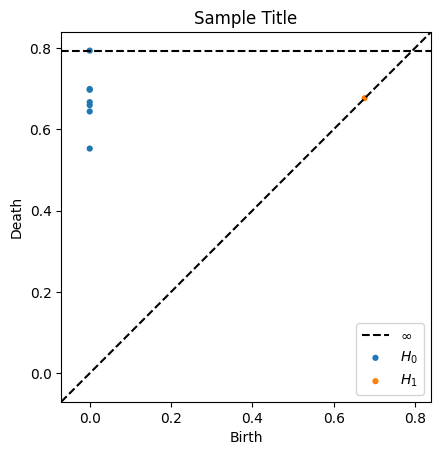

[[6.31720853e-07 6.25470564e-07 6.13125262e-07 5.95048300e-07
  5.71762805e-07 5.43926544e-07 5.12301090e-07 4.77717310e-07
  4.41039359e-07 4.03129325e-07]
 [6.69130892e-07 6.62510465e-07 6.49434084e-07 6.30286617e-07
  6.05622173e-07 5.76137469e-07 5.42639179e-07 5.06007373e-07
  4.67157382e-07 4.27002343e-07]
 [7.01709927e-07 6.94767161e-07 6.81054109e-07 6.60974380e-07
  6.35109058e-07 6.04188786e-07 5.69059511e-07 5.30644155e-07
  4.89902613e-07 4.47792482e-07]
 [7.28559177e-07 7.21350763e-07 7.07113014e-07 6.86264982e-07
  6.59409985e-07 6.27306623e-07 5.90833211e-07 5.50947984e-07
  5.08647564e-07 4.64926190e-07]
 [7.48915327e-07 7.41505507e-07 7.26869952e-07 7.05439419e-07
  6.77834087e-07 6.44833748e-07 6.07341258e-07 5.66341626e-07
  5.22859320e-07 4.77916359e-07]
 [7.62186544e-07 7.54645418e-07 7.39750512e-07 7.17940218e-07
  6.89845703e-07 6.56260579e-07 6.18103700e-07 5.76377531e-07
  5.32124693e-07 4.86385316e-07]
 [7.67981059e-07 7.60382601e-07 7.45374457e-07 7.23398350e

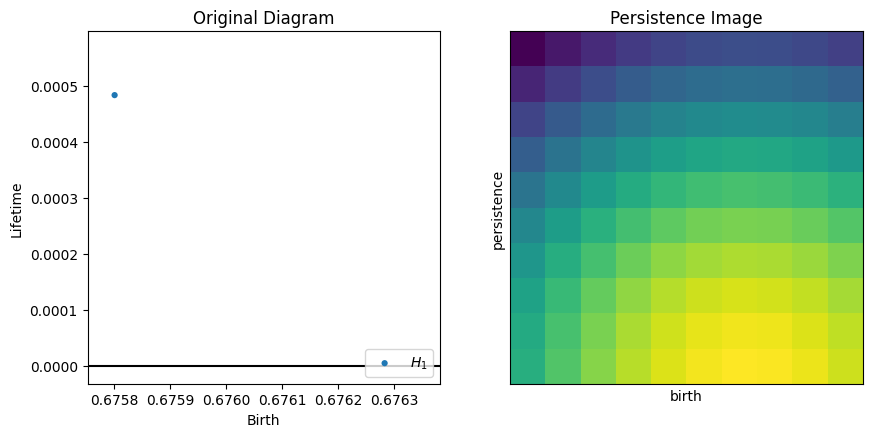

In [ ]:
import ripser
import persim

D = tempOutput
persistenceDiagrams = ripser.ripser(D, distance_matrix=True)['dgms']
persim.plot_diagrams(
    persistenceDiagrams, show=True,
    title=f"Sample Title"
)

from persim import PersistenceImager

# how to set this pixel size correctly?
pimager = PersistenceImager(pixel_size=0.1)

# The `transform()` method can then be called on one or more (*,2) numpy arrays to generate persistence images from diagrams.
persistenceImgs = pimager.transform(persistenceDiagrams[1:3])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].set_title("Original Diagram")
persim.plot_diagrams(persistenceDiagrams[1:3], lifetime=True, ax=axs[0], labels=["$H_1$", "$H_2$"])
axs[1].set_title("Persistence Image")
pimager.plot_image(persistenceImgs[0], ax=axs[1])
print(persistanceImgs[0])
print(persistenceImgs[0].shape)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


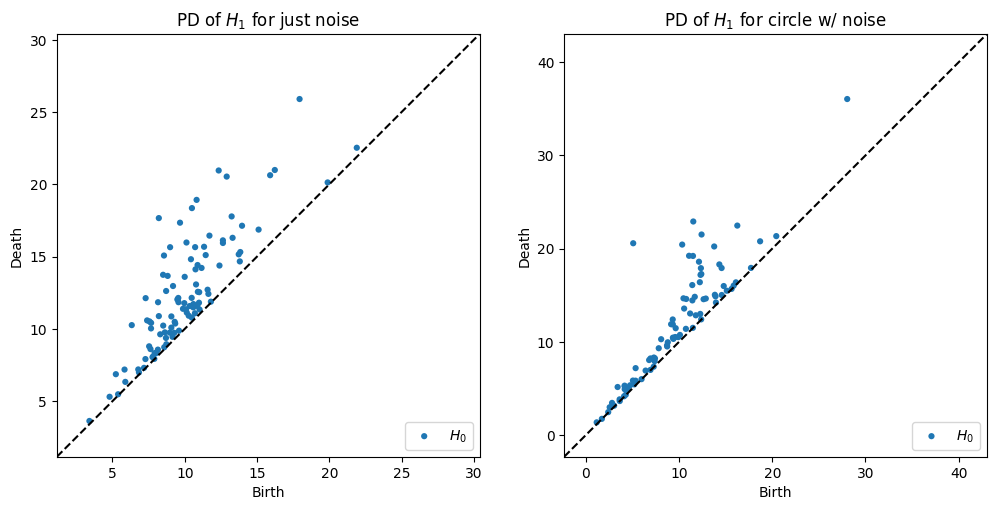

1.0


<Axes: title={'center': 'PI of $H_1$ for circle w/ noise'}, xlabel='birth', ylabel='persistence'>

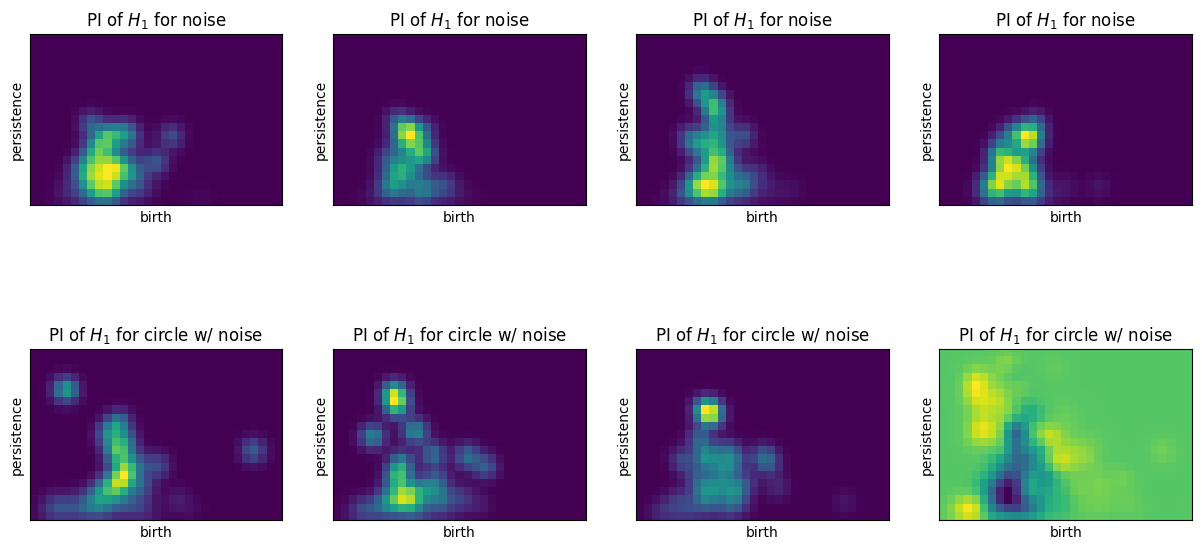

In [28]:
# testbed for logistic regression
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from ripser import Rips
from persim import PersImage
from persim import PersistenceImager


N = 200
N_per_class = int(N / 2)
N_in_class = 400

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    return offset + scale * datasets.make_circles(n_samples=N, factor=0.4, noise=0.05)[0]

just_noise = [noise(N_in_class, 150) for _ in range(N_per_class)]

half = int(N_in_class / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(half, 150)))
               for _ in range(N_per_class)]

datas = []
datas.extend(just_noise)
datas.extend(with_circle)
# need to start here with datas, which is an array

# Define labels
labels = np.zeros(N)
labels[N_per_class:] = 1

# for the section below, we want something like this:
# diagram = ripserFiltration(distances)
# diagrams_h0 = diagram[0]
# diagrams_h1 = diagram[1]
# diagrams_h2 = diagram[2]
# but clean out all the infs in the above lines

rips = Rips(maxdim=1, coeff=2)
# diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]


plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams_h1[0], show=False)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-1], show=False)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

# for the section below, we want something like this:
# pimgrH0 = PersistenceImager(pixel_size=1)
# pimgrH0.fit(diagrams_h0)
# imgsH0 = pimgr.transform(diagrams_h1)
# ...repeat last three lines for all dimensions

pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)

# for the section below, we want something like this:
# imgsH0_array = np.array([imgH0.flatten() for imgH0 in imgsH0])
# ...repeat last line for all dimensions

imgs_array = np.array([img.flatten() for img in imgs])


plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pimgr.plot_image(imgs[i], ax)
    plt.title("PI of $H_1$ for noise")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pimgr.plot_image(imgs[-(i+1)], ax)
    plt.title("PI of $H_1$ for circle w/ noise")

# for the section below, we want something like this:
# X_train, X_test, ytrain, y_test = train_test_split(imgsH0_array, labels, test_size=0.8, train_size=0.1)
# can we get rid of labels?
# lrH0 = LogisticRegression()
# lrH0.fit(X_train, y_train)
# scH0 = lrH0.score(X_test, y_test)
# print("H0 regression test score: ", sc)
# ...repeat all lines for all dimensions

X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
sc = lr.score(X_test, y_test)
print(sc)

inverse_image = np.copy(lr.coef_).reshape(pimgr.resolution)
pimgr.plot_image(inverse_image)

In [40]:
print(labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
## To wrap the array outputs for readability
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Gather 3 sets: human cases, AI cases, and test ("unknown") cases

# Determine a representative persistence diagram for human cases and AI cases? HOW?

# Compare each of the test cases against the representative diagrams, classify,
# and determine whether classification was successful or not

# suggest using
# https://persim.scikit-tda.org/en/latest/notebooks/distances.html

# Example
# if A and B are two Ripser persistence diagrams to be compared
#distance = persim.bottleneck(A, B, matching=False)
# and then just see whether the test case distance from human diagram is smaller
# or larger than distance from AI diagram. Classify based on smaller distance